<a href="https://colab.research.google.com/github/Zakaria-bls/data-science-project/blob/main/Two%20algorithms%20(small%20data)%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Spark OK ✅
Tentative de chargement du dataset vin blanc via URL: https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Dataset Wine (White) chargé via URL. ✅
Tentative de chargement du dataset vin rouge via URL: https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Dataset Wine (Red) chargé via URL. ✅
root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: long (nullable = true)

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 

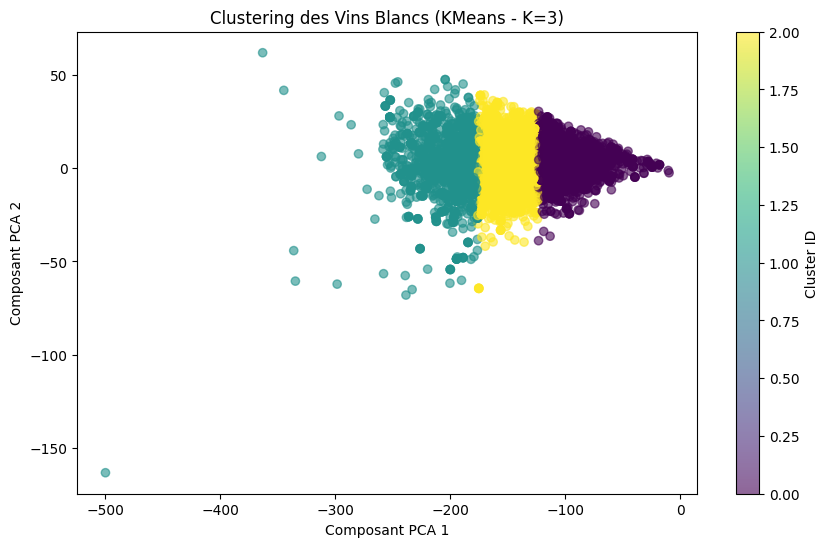

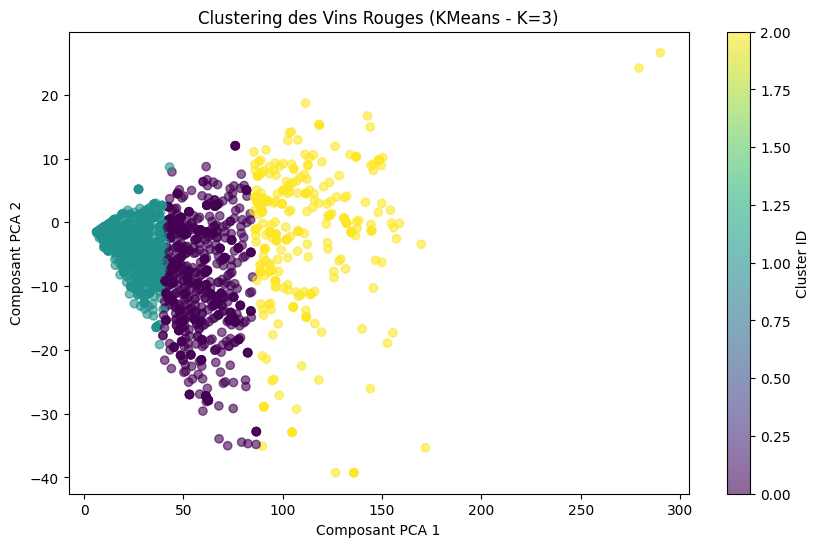


Résultats K-Means Spark pour le vin blanc:
    k      time       inertia  silhouette
0   3  5.508550  2.744930e+06    0.588113
1   5  3.975674  1.787462e+06    0.488674
2   8  2.984307  1.278450e+06    0.475110
3  10  2.749923  1.073565e+06    0.451734

Résultats K-Means Spark pour le vin rouge:
    k      time        inertia  silhouette
0   3  2.130942  395309.183456    0.686680
1   5  3.398467  233756.522866    0.662212
2   8  2.334907  160478.866750    0.489833
3  10  2.342294  106017.248723    0.562875


In [ ]:
# --- Cellule 1 (Setup) ---
from pyspark.sql import SparkSession
import pandas as pd
import time
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
import matplotlib.pyplot as plt

# Initialisation de la session Spark
spark = SparkSession.builder.appName("TP_BigData_Clustering").getOrCreate()
print("Spark OK ✅")

# --- Cellule 4 (Chargement des données via URL) ---
# URLs for the red and white wine datasets
url_white = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
url_red = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

print(f"Tentative de chargement du dataset vin blanc via URL: {url_white}")
try:
    wine_white = pd.read_csv(url_white, sep=";")
    print("Dataset Wine (White) chargé via URL. ✅")
except Exception as e:
    print(f"Échec du chargement via URL ({e}). Tentative de chargement du fichier local...")
    wine_white = pd.read_csv("winequality-white.csv", sep=";")
    print("Dataset Wine (White) chargé à partir du fichier local. ✅")

print(f"Tentative de chargement du dataset vin rouge via URL: {url_red}")
try:
    wine_red = pd.read_csv(url_red, sep=";")
    print("Dataset Wine (Red) chargé via URL. ✅")
except Exception as e:
    print(f"Échec du chargement via URL ({e}). Tentative de chargement du fichier local...")
    wine_red = pd.read_csv("winequality-red.csv", sep=";")
    print("Dataset Wine (Red) chargé à partir du fichier local. ✅")

# --- Cellule 10 & 11 (Conversion Pandas vers Spark et Feature Vector pour les deux vins) ---
# Convert white wine dataframe to Spark DataFrame
df_wine_white = spark.createDataFrame(wine_white)
df_wine_white.printSchema()

# Convert red wine dataframe to Spark DataFrame
df_wine_red = spark.createDataFrame(wine_red)
df_wine_red.printSchema()

# Prepare feature vectors for white wine
feature_cols_white = [c for c in df_wine_white.columns if c != "quality"]
assembler_white = VectorAssembler(inputCols=feature_cols_white, outputCol="features")
wine_spark_white = assembler_white.transform(df_wine_white).select("features")

# Prepare feature vectors for red wine
feature_cols_red = [c for c in df_wine_red.columns if c != "quality"]
assembler_red = VectorAssembler(inputCols=feature_cols_red, outputCol="features")
wine_spark_red = assembler_red.transform(df_wine_red).select("features")

# Prepare DataFrames for Scikit-learn steps (for further comparison if needed)
X_wine_white = wine_white.drop(columns=["quality"])
X_wine_red = wine_red.drop(columns=["quality"])

# --- Cellule 12 (Fonction KMeans avec Spark) ---
def run_kmeans_spark(df, k):
    t0 = time.perf_counter()

    kmeans = SparkKMeans(k=k, seed=0, featuresCol="features", predictionCol="prediction")
    model = kmeans.fit(df)
    predictions = model.transform(df)

    t1 = time.perf_counter()

    evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette")
    silhouette = evaluator.evaluate(predictions)
    inertia = model.summary.trainingCost

    return {
        "k": k,
        "time": t1 - t0,
        "inertia": inertia,
        "silhouette": silhouette,
        "predictions": predictions
    }

# --- Cellule 13 & 14 (Exécution et résultats Spark) ---
k_values_spark = [3, 5, 8, 10]
results_wine_spark_white = []
results_wine_spark_red = []
predictions_spark_white = None
predictions_spark_red = None

# Perform KMeans clustering on the white wine dataset
for k in k_values_spark:
    r = run_kmeans_spark(wine_spark_white, k)
    if k == 3:
        predictions_spark_white = r["predictions"]
    del r["predictions"]
    results_wine_spark_white.append(r)
    print(f"White Wine (K={k}): {r}")

# Perform KMeans clustering on the red wine dataset
for k in k_values_spark:
    r = run_kmeans_spark(wine_spark_red, k)
    if k == 3:
        predictions_spark_red = r["predictions"]
    del r["predictions"]
    results_wine_spark_red.append(r)
    print(f"Red Wine (K={k}): {r}")

# --- Cellule 15 (Visualisation Graphique des Clusters) ---
# Réduction des dimensions à 2D avec PCA pour la visualisation
pca_white = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model_white = pca_white.fit(wine_spark_white)
df_wine_pca_white = pca_model_white.transform(wine_spark_white)

# Apply PCA for red wine
pca_red = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model_red = pca_red.fit(wine_spark_red)
df_wine_pca_red = pca_model_red.transform(wine_spark_red)

# Join the PCA DataFrame with the predictions DataFrame for white wine
df_wine_pca_white_with_preds = df_wine_pca_white.join(predictions_spark_white, on=["features"])

# Join the PCA DataFrame with the predictions DataFrame for red wine
df_wine_pca_red_with_preds = df_wine_pca_red.join(predictions_spark_red, on=["features"])

# Convert to Pandas DataFrame for visualization (White wine)
wine_pca_pd_white = df_wine_pca_white_with_preds.select("prediction", "pca_features").toPandas()
wine_pca_pd_white['PCA_1'] = wine_pca_pd_white['pca_features'].apply(lambda x: x[0])
wine_pca_pd_white['PCA_2'] = wine_pca_pd_white['pca_features'].apply(lambda x: x[1])

# Convert to Pandas DataFrame for visualization (Red wine)
wine_pca_pd_red = df_wine_pca_red_with_preds.select("prediction", "pca_features").toPandas()
wine_pca_pd_red['PCA_1'] = wine_pca_pd_red['pca_features'].apply(lambda x: x[0])
wine_pca_pd_red['PCA_2'] = wine_pca_pd_red['pca_features'].apply(lambda x: x[1])

# Plotting the clusters for White Wine
plt.figure(figsize=(10, 6))
plt.scatter(wine_pca_pd_white['PCA_1'], wine_pca_pd_white['PCA_2'], c=wine_pca_pd_white['prediction'], cmap='viridis', alpha=0.6)
plt.title("Clustering des Vins Blancs (KMeans - K=3)")
plt.xlabel("Composant PCA 1")
plt.ylabel("Composant PCA 2")
plt.colorbar(label="Cluster ID")
plt.show()

# Plotting the clusters for Red Wine
plt.figure(figsize=(10, 6))
plt.scatter(wine_pca_pd_red['PCA_1'], wine_pca_pd_red['PCA_2'], c=wine_pca_pd_red['prediction'], cmap='viridis', alpha=0.6)
plt.title("Clustering des Vins Rouges (KMeans - K=3)")
plt.xlabel("Composant PCA 1")
plt.ylabel("Composant PCA 2")
plt.colorbar(label="Cluster ID")
plt.show()

# --- Cellule 16 (Résumé des Résultats) ---
# Résultats pour vin blanc
df_results_spark_white = pd.DataFrame(results_wine_spark_white)
print("\nRésultats K-Means Spark pour le vin blanc:")
print(df_results_spark_white)

# Résultats pour vin rouge
df_results_spark_red = pd.DataFrame(results_wine_spark_red)
print("\nRésultats K-Means Spark pour le vin rouge:")
print(df_results_spark_red)



{'k': 3, 'time': 0.270616488000087, 'inertia': 2744954.2301461305, 'silhouette': np.float64(0.4125412743885912), 'labels': array([2, 0, 1, ..., 1, 1, 1], dtype=int32)}
{'k': 5, 'time': 0.3770907639998313, 'inertia': 1749433.4054151163, 'silhouette': np.float64(0.3435489874919498), 'labels': array([3, 0, 0, ..., 0, 0, 0], dtype=int32)}
{'k': 8, 'time': 0.41236862499999916, 'inertia': 1257490.677152372, 'silhouette': np.float64(0.3036852551357516), 'labels': array([4, 3, 1, ..., 3, 3, 1], dtype=int32)}
{'k': 10, 'time': 1.1037208889999874, 'inertia': 1039188.5447907893, 'silhouette': np.float64(0.3068076275468802), 'labels': array([1, 0, 6, ..., 0, 0, 6], dtype=int32)}

Résultats K-Means Scikit-learn:
    k      time       inertia  silhouette  \
0   3  0.270616  2.744954e+06    0.412541   
1   5  0.377091  1.749433e+06    0.343549   
2   8  0.412369  1.257491e+06    0.303685   
3  10  1.103721  1.039189e+06    0.306808   

                                              labels  
0  [2, 0, 

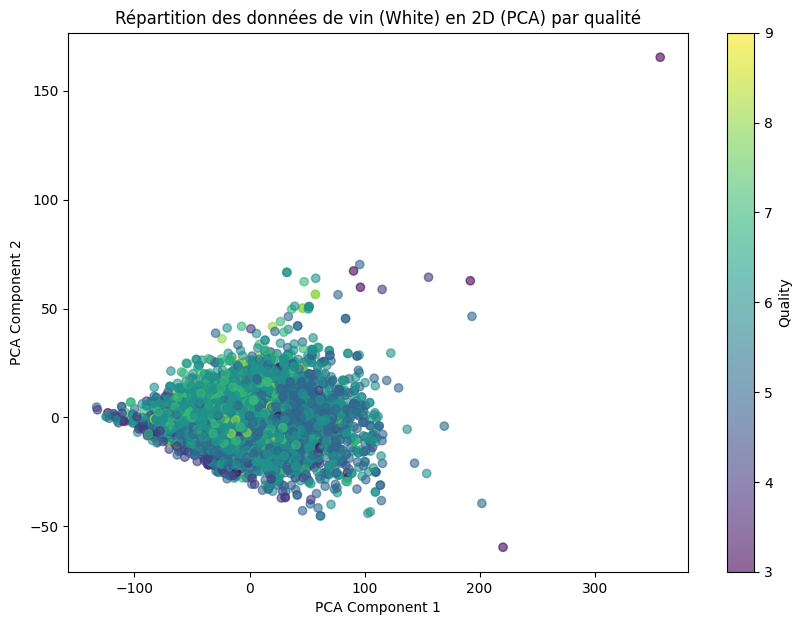

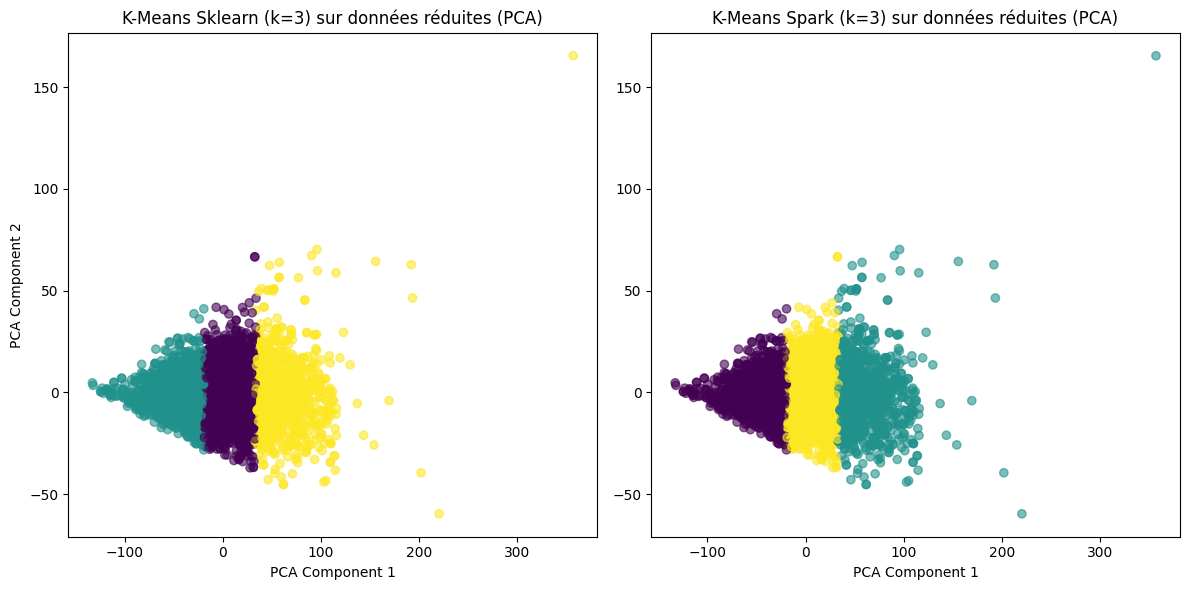


Matrice de contingence (Cross-tabulation) des clusters :
spark       0     1     2
sklearn                  
0           0     4  1975
1        1796     0     2
2           0  1121     0

Adjusted Rand Index (ARI) entre les clusters Spark et Sklearn : 0.9963

Spark session stopped.


In [ ]:
# --- Cellule 2 (Imports Scikit-learn/Matplotlib/Pandas) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.cluster import KMeans as SkKMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA

# --- Cellule 6 (Fonction KMeans scikit-learn) ---
def run_kmeans_sklearn(X, k):
    t0 = time.perf_counter()
    km = SkKMeans(n_clusters=k, n_init=10, max_iter=300, random_state=0)
    labels = km.fit_predict(X)
    t1 = time.perf_counter()
    return {
        "k": k,
        "time": t1 - t0,
        "inertia": km.inertia_,
        "silhouette": silhouette_score(X, labels),
        "labels": labels
    }

# --- Cellule 7, 8 & 9 (Exécution et résultats Scikit-learn) ---
k_values_sklearn = [3, 5, 8, 10]
results_wine_sklearn = []

for k in k_values_sklearn:
    res = run_kmeans_sklearn(X_wine, k)
    results_wine_sklearn.append(res)
    print(res)

df_results_sklearn = pd.DataFrame(results_wine_sklearn)
print("\nRésultats K-Means Scikit-learn:")
print(df_results_sklearn)
df_results_sklearn.to_csv("results_wine_sklearn.csv", index=False)


# --- Cellule 15 & 16 (PCA et Visualisation par Qualité) ---
print("\nGénération des visualisations...")
pca = PCA(n_components=2)
X_wine_2d = pca.fit_transform(X_wine)

# Visualisation par qualité réelle (contexte)
plt.figure(figsize=(10, 7))
plt.scatter(X_wine_2d[:, 0], X_wine_2d[:, 1], c=wine["quality"], cmap="viridis", alpha=0.6)
plt.title("Répartition des données de vin (White) en 2D (PCA) par qualité")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
cbar = plt.colorbar()
cbar.set_label("Quality")
plt.show()

# --- Cellule 17 & 18 (Clustering et Visualisation) ---
# Affecter les clusters avec k=3 pour Sklearn
km_sklearn = SkKMeans(n_clusters=3, n_init=10, max_iter=300, random_state=0)
labels_sklearn = km_sklearn.fit_predict(X_wine)

# Convertir les prédictions Spark (du Bloc 1)
labels_spark = predictions_spark.select("prediction").rdd.map(lambda row: row[0]).collect()
labels_spark = np.array(labels_spark)

# Affichage des résultats Sklearn vs Spark
plt.figure(figsize=(12, 6))

# Subplot 1: KMeans Sklearn clustering results
plt.subplot(1, 2, 1)
plt.scatter(X_wine_2d[:, 0], X_wine_2d[:, 1], c=labels_sklearn, cmap="viridis", alpha=0.6)
plt.title("K-Means Sklearn (k=3) sur données réduites (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Subplot 2: KMeans Spark clustering results
plt.subplot(1, 2, 2)
plt.scatter(X_wine_2d[:, 0], X_wine_2d[:, 1], c=labels_spark, cmap="viridis", alpha=0.6)
plt.title("K-Means Spark (k=3) sur données réduites (PCA)")
plt.xlabel("PCA Component 1")

plt.tight_layout()
plt.show()


# --- Cellule 19, 20 & 21 (Comparaison et Arrêt) ---
print("\nMatrice de contingence (Cross-tabulation) des clusters :")
cross_tab = pd.crosstab(labels_sklearn, labels_spark, rownames=["sklearn"], colnames=["spark"])
print(cross_tab)

ari = adjusted_rand_score(labels_sklearn, labels_spark)
print(f"\nAdjusted Rand Index (ARI) entre les clusters Spark et Sklearn : {ari:.4f}")

# Arrêter la session Spark (initialisée dans le Bloc 1)
spark.stop()
print("\nSpark session stopped.")
